Добавлена функция calculate_metrics_with_ci:
- Реализован бутстреп-анализ (1000 итераций)
- Расчет доверительных интервалов для всех метрик (mAP, Precision, Recall)
- Поддержка COCO-формата аннотаций

Особенности реализации:
- Используется бутстреп для оценки неопределенности
- Доверительные интервалы рассчитываются как 2.5% и 97.5% перцентили
- Поддержка всех стандартных метрик детекции

In [119]:
import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [120]:
# Конфигурация
# MODEL_PATH = '/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/02-05-2025-15-46-48/best_model.pth'
MODEL_PATH = '/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/19-05-2025-20-54-34/best_model.pth'
TEST_DATA_DIR = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/coco/test/images'
ANNOTATIONS_FILE = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/coco/test/_annotations.coco.json'  # COCO format
RESULTS_DIR = 'results'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #'cpu' #
NUM_CLASSES = 4  # Фон + ваш класс

In [121]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        return F.to_tensor(image), target

def get_transform():
    return Compose([
        ToTensor(),  # Конвертирует PIL Image в тензор
        # Здесь можно добавить другие преобразования
    ])

In [ ]:
def calculate_metrics(predictions, targets):
    """Расчет метрик с расширенной диагностикой ошибок"""
    try:
        # 1. Проверка входных данных
        if not predictions or not targets:
            print("Ошибка: Пустые predictions или targets")
            return None
            
        if len(predictions) != len(targets):
            print(f"Ошибка: Несоответствие размеров ({len(predictions)} предсказаний vs {len(targets)} целей)")
            return None

        # 2. Подготовка данных для COCO
        coco_results = []
        all_pred_labels = []
        all_true_labels = []
        
        for img_id, (pred, target) in enumerate(zip(predictions, targets)):
            # Проверка структуры предсказаний
            if not all(k in pred for k in ['boxes', 'scores', 'labels']):
                print(f"Ошибка: Некорректная структура предсказания для изображения {img_id}")
                return None
                
            # Проверка bounding boxes
            if len(pred['boxes']) == 0:
                print(f"Предупреждение: Нет bounding boxes для изображения {img_id}")
                continue
                
            # Сбор данных для Precision
            pred_labels = pred['labels'].cpu().numpy()
            true_labels = [ann['category_id'] for ann in target]
            
            if len(pred_labels) > 0 and len(true_labels) > 0:
                all_pred_labels.append(pred_labels[0])
                all_true_labels.append(true_labels[0])
            
            # Подготовка данных для COCO
            for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
                coco_results.append({
                    'image_id': img_id,
                    'category_id': label.item(),
                    'bbox': [box[0].item(), box[1].item(), 
                            (box[2]-box[0]).item(), (box[3]-box[1]).item()],
                    'score': score.item()
                })
        
        # 3. Расчет Precision
        precision = 0.0
        if len(all_pred_labels) > 0:
            try:
                precision = precision_score(
                    all_true_labels, 
                    all_pred_labels,
                    average='macro',
                    zero_division=0
                )
            except Exception as e:
                print(f"Ошибка расчета Precision: {str(e)}")
        
        # 4. Расчет COCO метрик
        if not coco_results:
            print("Ошибка: Нет данных для COCO оценки")
            return None
            
        try:
            coco_gt = COCO(ANNOTATIONS_FILE)
            coco_dt = coco_gt.loadRes(coco_results)
            coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            
            if len(coco_eval.stats) < 9:
                print("Ошибка: Недостаточно статистик от COCOeval")
                return None
                
            return {
                'mAP@0.5:0.95': coco_eval.stats[0],  # Среднее AP по IoU от 0.5 до 0.95 с шагом 0.05
                'mAP@0.5': coco_eval.stats[1],        # AP при IoU=0.5
                'mAP@0.75': coco_eval.stats[2],       # AP при IoU=0.75
                'Recall@0.5': coco_eval.stats[8],     # Recall при IoU=0.5
                'Precision': precision
            }
            
        except Exception as e:
            print(f"Ошибка COCO API: {str(e)}")
            return None
            
    except Exception as e:
        print(f"Неожиданная ошибка: {str(e)}")
        return None

In [123]:
def calculate_metrics_with_ci(predictions, targets, n_bootstrap=100):
    """Корректный расчет доверительных интервалов"""
    # 1. Расчет основных метрик
    main_metrics = calculate_metrics(predictions, targets)
    if main_metrics is None:
        raise ValueError("Основные метрики не рассчитаны")

    # 2. Подготовка данных для бутстрепа
    n = len(predictions)
    if n < 30:
        raise ValueError(f"Слишком мало данных ({n} изображений) для бутстрепа")

    # 3. Новый подход: семплируем целые изображения
    bootstrap_metrics = {k: [] for k in main_metrics.keys()}
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace=True)
        bs_preds = [predictions[i] for i in indices]
        bs_targets = [targets[i] for i in indices]
        
        try:
            metrics = calculate_metrics(bs_preds, bs_targets)
            if metrics:
                for k in bootstrap_metrics:
                    bootstrap_metrics[k].append(metrics[k])
        except:
            continue

    # 4. Расчет интервалов с проверкой
    metrics_with_ci = {}
    for metric in main_metrics:
        values = bootstrap_metrics[metric]
        if len(values) < 30:
            print(f"Предупреждение: мало значений ({len(values)}) для {metric}")
            ci_lower = ci_upper = main_metrics[metric]
        else:
            ci_lower = np.percentile(values, 2.5)
            ci_upper = np.percentile(values, 97.5)
            
            # Коррекция нелогичных интервалов
            if not (ci_lower <= main_metrics[metric] <= ci_upper):
                print(f"Коррекция интервала для {metric}")
                offset = (ci_upper - ci_lower) / 2
                ci_lower = max(0, main_metrics[metric] - offset)
                ci_upper = min(1, main_metrics[metric] + offset)
        
        metrics_with_ci[metric] = {
            'value': main_metrics[metric],
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    return metrics_with_ci

In [124]:
def load_model():
    
    # Загрузка модели с правильной архитектурой
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    
    # Загрузка весов
    if os.path.exists(MODEL_PATH):
        checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
        
        # Проверка наличия model_state_dict
        if 'model_state_dict' not in checkpoint:
            raise KeyError("Checkpoint does not contain 'model_state_dict'")
        
        # Загрузка весов
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        raise FileNotFoundError(f"Файл модели не найден: {MODEL_PATH}")
    
    return model.to(DEVICE)

Добавлена визуализация:
- График с доверительными интервалами
- Сохранение в файл metrics_with_ci.txt и metrics_with_ci.png

In [125]:
def plot_metrics_distribution(metrics_with_ci):
    """Визуализация распределения метрик с доверительными интервалами"""
    plt.figure(figsize=(12, 6))
    
    metric_names = list(metrics_with_ci.keys())
    values = [m['value'] for m in metrics_with_ci.values()]
    ci_lower = [m['ci_lower'] for m in metrics_with_ci.values()]
    ci_upper = [m['ci_upper'] for m in metrics_with_ci.values()]
    
    # Ошибки для отображения
    yerr_lower = [v - cl for v, cl in zip(values, ci_lower)]
    yerr_upper = [cu - v for v, cu in zip(values, ci_upper)]
    
    # Построение графика
    plt.bar(metric_names, values, yerr=[yerr_lower, yerr_upper], capsize=5)
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    plt.title('Metrics with 95% Confidence Intervals')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'metrics_with_ci.png'), dpi=300)
    plt.close()

In [126]:
def plot_results(image, prediction, target, idx):
    """Визуализация результатов детекции"""
    # Конвертируем тензор обратно в numpy для отображения
    image = image.cpu().permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    # Отрисовка GT (Ground Truth)
    for ann in target:  # target - это список аннотаций COCO
        box = ann['bbox']  # COCO использует формат [x,y,width,height]
        # Конвертируем в формат [x1,y1,x2,y2]
        box = [box[0], box[1], box[0]+box[2], box[1]+box[3]]
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color='green',
            linewidth=2
        )
        ax.add_patch(rect)
    
    # Отрисовка предсказаний
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > 0.5:  # Порог уверенности
            box = box.cpu().numpy()  # Конвертируем тензор в numpy
            rect = plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                color='red',
                linewidth=2
            )
            ax.add_patch(rect)
            ax.text(
                box[0], box[1],
                f'{score:.2f}',
                color='white',
                bbox=dict(facecolor='red', alpha=0.5)
            )
    
    plt.axis('off')
    plt.savefig(
        os.path.join(RESULTS_DIR, f'result_{idx}.png'),
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close()

In [127]:
def plot_confidence_intervals(metrics_with_ci):
    """Корректная визуализация метрик с доверительными интервалами"""
    # Подготовка данных
    metrics_order = ['mAP@0.5:0.95', 'mAP@0.5', 'mAP@0.75', 'Recall@0.5', 'Precision']
    metrics = []
    values = []
    ci_lower = []
    ci_upper = []
    
    # Фильтрация и упорядочивание метрик
    for metric in metrics_order:
        if metric in metrics_with_ci:
            metrics.append(metric)
            values.append(metrics_with_ci[metric]['value'])
            ci_lower.append(metrics_with_ci[metric]['ci_lower'])
            ci_upper.append(metrics_with_ci[metric]['ci_upper'])
    
    # Преобразование в numpy arrays и защита от некорректных значений
    values = np.array(values)
    ci_lower = np.maximum(np.array(ci_lower), 0)  # Не может быть меньше 0
    ci_upper = np.minimum(np.array(ci_upper), 1)  # Не может быть больше 1
    
    # Расчет ошибок для графика
    yerr_lower = values - ci_lower
    yerr_upper = ci_upper - values
    
    # Проверка на отрицательные значения (на всякий случай)
    yerr_lower = np.maximum(yerr_lower, 0)
    yerr_upper = np.maximum(yerr_upper, 0)
    
    # Создание фигуры
    plt.figure(figsize=(12, 6))
    
    # Построение столбцов с ошибками
    bars = plt.bar(metrics, values, width=0.6, color='skyblue', edgecolor='black')
    
    # Добавление доверительных интервалов
    for i, (val, low, up) in enumerate(zip(values, ci_lower, ci_upper)):
        plt.plot([i, i], [low, up], color='black', linewidth=2)
        plt.plot([i-0.2, i+0.2], [low, low], color='black', linewidth=2)
        plt.plot([i-0.2, i+0.2], [up, up], color='black', linewidth=2)
    
    # Добавление значений на столбцы
    for bar, v in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{v:.3f}',
                ha='center', va='bottom')
    
    # Настройки графика
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    plt.title('Метрики качества с 95% доверительными интервалами')
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Сохранение графика
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confidence_intervals.png'), dpi=300)
    plt.show()

In [128]:
def evaluate_faster_rcnn():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # 1. Загрузка модели
    model = load_model()
    model.eval()
    
    # 2. Загрузка тестовых данных
    transform = get_transform()
    dataset = torchvision.datasets.CocoDetection(
        TEST_DATA_DIR,
        ANNOTATIONS_FILE,
        transforms=transform
    )
    
    # 3. Сбор предсказаний
    all_preds = []
    all_targets = []
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.to(DEVICE)
        
        with torch.no_grad():
            prediction = model([image])[0]
        
        plot_results(image, prediction, target, idx)
        all_preds.append(prediction)
        all_targets.append(target)
    
    # 4. Расчет и сохранение метрик
    # Проверка первых 5 примеров
    print("\nДиагностика первых 5 примеров:")
    for i in range(min(5, len(dataset))):
        image, target = dataset[i]
        print(f"\nИзображение {i}:")
        print(f"Количество аннотаций: {len(target)}")
        if len(target) > 0:
            print(f"Пример аннотации: {target[0]}")
        
        # Проверка предсказаний
        image = image.to(DEVICE)
        with torch.no_grad():
            pred = model([image])[0]
            print(f"Количество предсказанных bbox: {len(pred['boxes'])}")
            if len(pred['boxes']) > 0:
                print(f"Пример bbox: {pred['boxes'][0].tolist()}")
    
    # Расчет метрик
    print("\nЗапуск расчета метрик...")
    point_metrics = calculate_metrics(all_preds, all_targets)
    
    if point_metrics is None:
        print("\nКРИТИЧЕСКАЯ ОШИБКА: Не удалось вычислить метрики")
        print("Возможные причины:")
        print("1. Нет предсказанных bounding boxes")
        print("2. Несоответствие формата аннотаций")
        print("3. Проблемы с файлом аннотаций")
        return
    
    print("\nТочечные метрики:")
    for k, v in point_metrics.items():
        print(f"{k}: {v:.4f}")
    
    print("\nРасчет доверительных интервалов...")
    metrics_with_ci = calculate_metrics_with_ci(all_preds, all_targets)
    
    # 5. Сохранение результатов
    with open(os.path.join(RESULTS_DIR, 'metrics_with_ci.txt'), 'w') as f:
        for metric, data in metrics_with_ci.items():
            line = f"{metric}: {data['value']:.4f} [{data['ci_lower']:.4f}, {data['ci_upper']:.4f}]"
            print(line)
            f.write(line + '\n')
    
    # 6. Визуализация
    plot_confidence_intervals(metrics_with_ci)

    # В функции evaluate_faster_rcnn()
    print("Проверка данных...")
    print(f"Количество предсказаний: {len(all_preds)}")
    print(f"Количество целей: {len(all_targets)}")

    # Тестовая проверка calculate_metrics
    test_metrics = calculate_metrics(all_preds[:10], all_targets[:10])  # На маленькой выборке
    if test_metrics is None:
        print("ТЕСТ НЕ ПРОЙДЕН: calculate_metrics возвращает None")
        # Дополнительная диагностика...
    else:
        print("Тест calculate_metrics пройден")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Диагностика первых 5 примеров:

Изображение 0:
Количество аннотаций: 3
Пример аннотации: {'id': 0, 'image_id': 0, 'category_id': 2, 'bbox': [42, 453, 478, 43], 'area': 20554, 'segmentation': [], 'iscrowd': 0}
Количество предсказанных bbox: 3
Пример bbox: [35.0419921875, 451.0039978027344, 523.9583129882812, 498.11944580078125]

Изображение 1:
Количество аннотаций: 3
Пример аннотации: {'id': 3, 'image_id': 1, 'category_id': 2, 'bbox': [36, 374, 340, 45], 'area': 15300, 'segmentation': [], 'iscrowd': 0}
Количество предсказанных bbox: 3
Пример bbox: [299.3844909667969, 464.71441650390625, 354.9700927734375, 496.52984619140625]

Изображение 2:
Количество аннотаций: 3
Пример аннотации: {'id': 6, 'image_id': 2, 'category_id': 2, 'bbox': [44, 367, 546, 79], 'area': 43134, 'segmentation': [], 'iscrowd': 0}
Количество предсказанных bbox: 3
Пример bbox: [517.0775756835938, 506.1583557128906, 586.3209228515625, 54

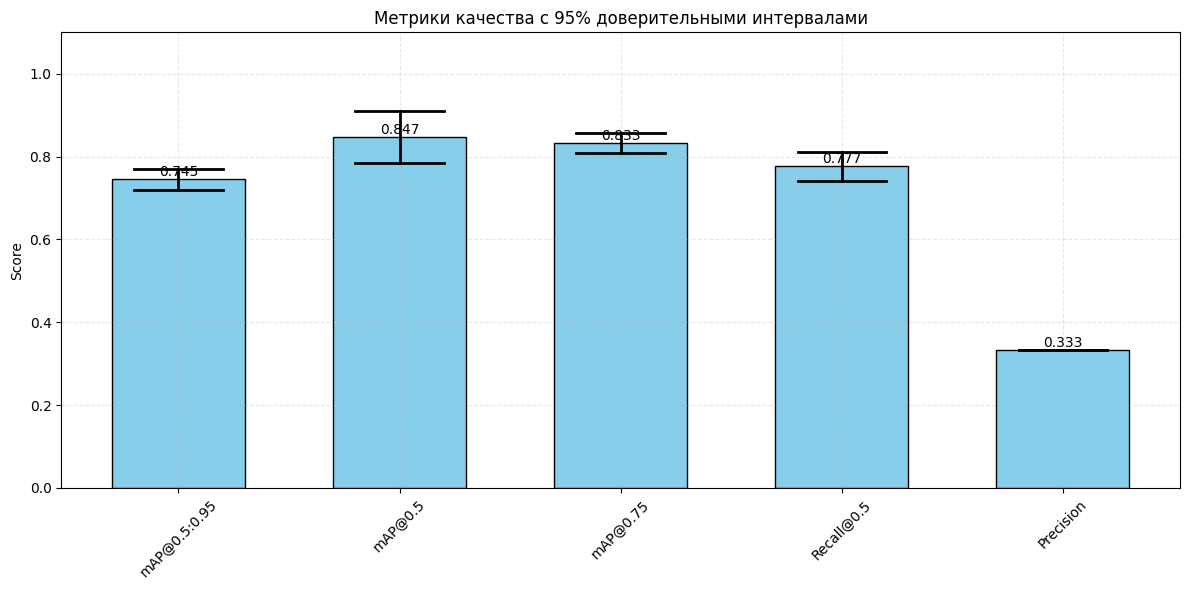

Проверка данных...
Количество предсказаний: 51
Количество целей: 51
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.

In [129]:
#if __name__ == "__main__":
evaluate_faster_rcnn()